<a href="https://colab.research.google.com/github/malinphy/q_17/blob/main/biogpt_variants_biogpt_large.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## biotech patent data, biogptlarge, biogptlarge_pubmedQA

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install scann -q

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.5/10.5 MB 65.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 84.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 kB 32.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 68.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 85.6 MB/s eta 0:00:00


In [2]:
import numpy as np 
import pandas as pd 
from platform import python_version
import os 
import sklearn
import json
# from data_loader import patent_data
# from data_diluter import normalizer
# from data_diluter import  diluted_df
from sklearn.decomposition import TruncatedSVD, PCA
import joblib
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import scann

In [3]:
os.listdir('drive/MyDrive/transfer/biogpt_variants/biogpt_large')

['data_biotech_title_biogpt_large.npy',
 'data_biotech_abstract_biogpt_large.npy',
 'data_biotech_abstract_biogpt_large_norm.npy',
 'data_biotech_title_biogpt_large_norm.npy',
 'data_nih_title_biogpt_large_norm.npy',
 'data_nih_abstract_biogpt_large_norm.npy',
 'data_nih_abstract_biogpt_large.npy',
 'data_nih_title_biogpt_large.npy']

In [4]:
# biotech_abstract_biogpt_large = np.load('./data_biotech_abstract_biogpt_large_norm.npy')
# biotech_title_biogpt_large = np.load('./data_biotech_title_biogpt_large_norm.npy')

In [5]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

def apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0
    hits = []
    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)
        hits.append(num_hits)
    # if not actual:
    #     return 0.0
    # print(((hits)))
    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

def intersect(actual, predicted,k):
    return np.intersect1d(actual[:k], predicted[:k])

def hit_rate(actual, predicted,k):
    total = 0
    for i in range(len(actual)):
        intersection = intersect(actual[i], predicted[i],k)
        total = total + len(intersection)

    return total


def mean_reciprocal_rank(idx, k):
    rank = []
    for i in range(len(idx)):
        rank.append(np.where(idx[i][:k] == i)[0])

    elevated_rank = np.add(rank,1)
    elevated_rank = np.concatenate(elevated_rank)
    elevated_rank_len = len(elevated_rank)
    reciprocal_rank = np.divide(1,elevated_rank)
    reciprocal_rank_sum = np.sum(reciprocal_rank)
    # print('asfasfasfas',len(idx))
    # return reciprocal_rank_sum/elevated_rank_len
    return reciprocal_rank_sum/len(idx)    

def dcg_calc(similarity_scores, K):
    similarity_len = len(similarity_scores)
    total_dcg = []
    for similarities in similarity_scores:
        dcg = 0
        for k in range(1,K):
            rel_k = similarities[k-1]
            dcg += rel_k / log2(1 + k)
        total_dcg.append(dcg)
    return np.sum(total_dcg)/similarity_len    

def metrics_calculator(raw_idx, reduced_idx, k_values):
    k = k_values
    ap = []
    hit = []
    mrr = []
    for i in k:
        ap.append( mapk(raw_idx, reduced_idx,i))
        hit.append( hit_rate(raw_idx, reduced_idx,i))
        mrr.append(mean_reciprocal_rank(reduced_idx, i))
    return ap, hit , mrr  

In [6]:
def vector_normalizer(x):     
    normalized_vector = x / np.linalg.norm(x)
    return normalized_vector

In [7]:
biotech_abstract_biogpt_large = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large/data_biotech_abstract_biogpt_large_norm.npy')
biotech_title_biogpt_large = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large/data_biotech_title_biogpt_large_norm.npy')

biotech_abstract_biogpt_large_pubmed_qa = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large_pubmed_qa/data_biotech_abstract_biogpt_Large_PubMedQA_norm.npy')
biotech_title_biogpt_large_pubmed_qa = np.load('drive/MyDrive/transfer/biogpt_variants/biogpt_large_pubmed_qa/data_biotech_title_biogpt_Large_PubMedQA_norm.npy')

Text(0.5, 1.0, 'biogpt_large')

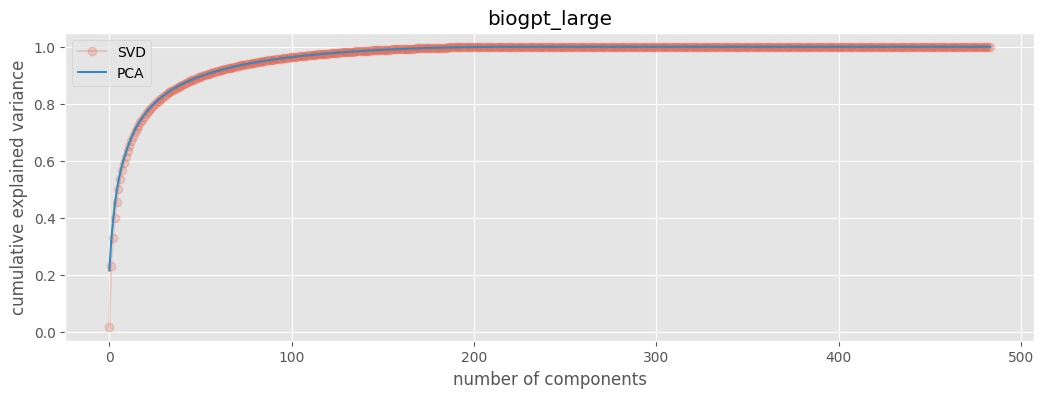

In [8]:
pca_biogpt_large = PCA().fit(biotech_abstract_biogpt_large)
pca_var_biogpt_large = np.cumsum(pca_biogpt_large.explained_variance_ratio_)

svd_content_biogpt_large = TruncatedSVD(n_iter= 25, n_components = 1600 ).fit(biotech_abstract_biogpt_large)
svd_var_biogpt_large = np.cumsum(svd_content_biogpt_large.explained_variance_ratio_)
     
plt.figure(figsize = (12.5,4))
plt.plot(svd_var_biogpt_large, marker = 'o', alpha =0.2)
plt.plot(pca_var_biogpt_large)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])
plt.title('biogpt_large')

In [9]:
print('PCA 100% :',np.where(np.array(pca_var_biogpt_large) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var_biogpt_large) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_biogpt_large) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_biogpt_large) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_biogpt_large) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_biogpt_large) >= 0.90)[0][0])


PCA 100% : 153
SVD 100% : 154
PCA 95% : 85
SVD 95% : 86
PCA 90% : 52
SVD 90% : 53


Text(0.5, 1.0, 'biogpt_large_pubmed')

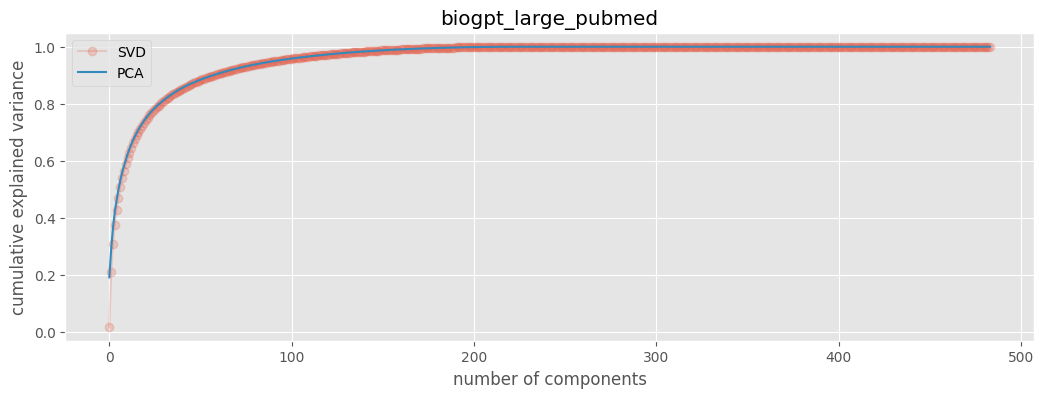

In [10]:
pca_biogpt_large_pubmed_qa = PCA().fit(biotech_abstract_biogpt_large_pubmed_qa)
pca_var_biogpt_large_pubmed_qa = np.cumsum(pca_biogpt_large_pubmed_qa.explained_variance_ratio_)

svd_content_biogpt_large_pubmed_qa = TruncatedSVD(n_iter= 25, n_components = 1600 ).fit(biotech_abstract_biogpt_large_pubmed_qa)
svd_var_biogpt_large_pubmed_qa = np.cumsum(svd_content_biogpt_large_pubmed_qa.explained_variance_ratio_)
     
plt.figure(figsize = (12.5,4))
plt.plot(svd_var_biogpt_large_pubmed_qa, marker = 'o', alpha =0.2)
plt.plot(pca_var_biogpt_large_pubmed_qa)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.legend(['SVD','PCA'])
plt.title('biogpt_large_pubmed')

In [11]:
print('PCA 100% :',np.where(np.array(pca_var_biogpt_large_pubmed_qa) >= 0.99)[0][0])
print('SVD 100% :',np.where(np.array(svd_var_biogpt_large_pubmed_qa) >= 0.99)[0][0])
print('PCA 95% :',np.where(np.array(pca_var_biogpt_large_pubmed_qa) >= 0.95)[0][0])
print('SVD 95% :',np.where(np.array(svd_var_biogpt_large_pubmed_qa) >= 0.95)[0][0])
print('PCA 90% :',np.where(np.array(pca_var_biogpt_large_pubmed_qa) >= 0.90)[0][0])
print('SVD 90% :',np.where(np.array(svd_var_biogpt_large_pubmed_qa) >= 0.90)[0][0])

PCA 100% : 158
SVD 100% : 159
PCA 95% : 91
SVD 95% : 92
PCA 90% : 57
SVD 90% : 58


In [12]:
def pca_reducer(target_dimension, content, title):
    pca_name = '_pca_'+str(target_dimension)
    pca_ = PCA(n_components=target_dimension, random_state = 42, svd_solver = 'arpack')
    pca_.fit(content)
    content_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(content))
    title_vectors_pca = np.apply_along_axis(vector_normalizer,1,pca_.transform(title))

    inverse_content = pca_.inverse_transform(content_vectors_pca)
    inverse_title = pca_.inverse_transform(title_vectors_pca)

    np.save('./patent_abst_vectors_norm'+pca_name,content_vectors_pca)
    np.save('./patent_title_vectors_norm'+pca_name,title_vectors_pca)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+pca_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+pca_name, inverse_title)
    joblib.dump(pca_, pca_name)

def svd_reducer(target_dimension, content, title):
    svd_name = '_svd_'+str(target_dimension)
    svd_ = TruncatedSVD(n_iter= 25, n_components = target_dimension, random_state = 42 )
    svd_.fit(content)
    content_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(content))
    title_vectors_svd = np.apply_along_axis(vector_normalizer,1,svd_.transform(title))

    inverse_content = svd_.inverse_transform(content_vectors_svd)
    inverse_title = svd_.inverse_transform(title_vectors_svd)

    np.save('./patent_abst_vectors_norm'+svd_name,content_vectors_svd)
    np.save('./patent_title_vectors_norm'+svd_name,title_vectors_svd)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_content_vectors_norm'+svd_name, inverse_content)
#     np.save('drive/MyDrive/transfer/reduced_dim/inverse_title_vectors_norm'+svd_name, inverse_title)
    joblib.dump(svd_, svd_name)

In [13]:
pca_reducer(53, biotech_abstract_biogpt_large, biotech_title_biogpt_large)
svd_reducer(53, biotech_abstract_biogpt_large, biotech_title_biogpt_large)

pca_reducer(86, biotech_abstract_biogpt_large, biotech_title_biogpt_large)
svd_reducer(86, biotech_abstract_biogpt_large, biotech_title_biogpt_large)

pca_reducer(107, biotech_abstract_biogpt_large, biotech_title_biogpt_large)
svd_reducer(107, biotech_abstract_biogpt_large, biotech_title_biogpt_large)

pca_reducer(154, biotech_abstract_biogpt_large, biotech_title_biogpt_large)
svd_reducer(154, biotech_abstract_biogpt_large, biotech_title_biogpt_large)

In [14]:
abstract_pca_53 = np.load('./patent_abst_vectors_norm_pca_53.npy')
abstract_pca_86 = np.load('./patent_abst_vectors_norm_pca_86.npy')
abstract_pca_154 = np.load('./patent_abst_vectors_norm_pca_154.npy')
abstract_pca_107 = np.load('./patent_abst_vectors_norm_pca_107.npy')

abstract_svd_53 = np.load('./patent_abst_vectors_norm_svd_53.npy')
abstract_svd_86 = np.load('./patent_abst_vectors_norm_svd_86.npy')
abstract_svd_154 = np.load('./patent_abst_vectors_norm_svd_154.npy')
abstract_svd_107 = np.load('./patent_abst_vectors_norm_svd_107.npy')

title_pca_53 = np.load('./patent_title_vectors_norm_pca_53.npy')
title_pca_86 = np.load('./patent_title_vectors_norm_pca_86.npy')
title_pca_154 = np.load('./patent_title_vectors_norm_pca_154.npy')
title_pca_107 = np.load('./patent_title_vectors_norm_pca_107.npy')

title_svd_53 = np.load('./patent_title_vectors_norm_svd_53.npy')
title_svd_86 = np.load('./patent_title_vectors_norm_svd_86.npy')
title_svd_154 = np.load('./patent_title_vectors_norm_svd_154.npy')
title_svd_107 = np.load('./patent_title_vectors_norm_svd_107.npy')

In [15]:
biotech_abstract_biogpt_large, biotech_title_biogpt_large
searcher_raw = scann.scann_ops_pybind.builder(biotech_abstract_biogpt_large, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_53 = scann.scann_ops_pybind.builder(abstract_pca_53, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_86 = scann.scann_ops_pybind.builder(abstract_pca_86, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_154 = scann.scann_ops_pybind.builder(abstract_pca_154, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_pca_107 = scann.scann_ops_pybind.builder(abstract_pca_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    
  
searcher_svd_53 = scann.scann_ops_pybind.builder(abstract_svd_53, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_86 = scann.scann_ops_pybind.builder(abstract_svd_86, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

searcher_svd_154 = scann.scann_ops_pybind.builder(abstract_svd_154, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    
     
searcher_svd_107 = scann.scann_ops_pybind.builder(abstract_svd_107, 50, "dot_product").tree(
    num_leaves=200, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()    

In [16]:
raw_idx = []
reduced_idx_pca_53 = []
reduced_idx_svd_53 = []
reduced_idx_pca_86 = []
reduced_idx_svd_86 = []
reduced_idx_pca_154 = []
reduced_idx_svd_154 = []
reduced_idx_pca_107 = []
reduced_idx_svd_107 = []
for i in range(len(biotech_abstract_biogpt_large)):
    raw_idx.append(searcher_raw.search(biotech_title_biogpt_large[i])[0])
    reduced_idx_pca_53.append(searcher_pca_53.search(title_pca_53[i])[0])
    reduced_idx_svd_53.append(searcher_svd_53.search(title_svd_53[i])[0])
    reduced_idx_pca_86.append(searcher_pca_86.search(title_pca_86[i])[0])
    reduced_idx_svd_86.append(searcher_svd_86.search(title_svd_86[i])[0])
    reduced_idx_pca_154.append(searcher_pca_154.search(title_pca_154[i])[0])
    reduced_idx_svd_154.append(searcher_svd_154.search(title_svd_154[i])[0])
    reduced_idx_pca_107.append(searcher_pca_107.search(title_pca_107[i])[0])
    reduced_idx_svd_107.append(searcher_svd_107.search(title_svd_107[i])[0])    

In [17]:
k = [1,3,5,10,15,20,30]
ap_pca_53, hit_pca_53, mrr_pca_53 = metrics_calculator(raw_idx,reduced_idx_pca_53, k )
ap_svd_53, hit_svd_53, mrr_svd_53 = metrics_calculator(raw_idx,reduced_idx_svd_53, k )

ap_pca_86, hit_pca_86, mrr_pca_86 = metrics_calculator(raw_idx,reduced_idx_pca_86, k )
ap_svd_86, hit_svd_86, mrr_svd_86 = metrics_calculator(raw_idx,reduced_idx_svd_86, k )

ap_pca_154, hit_pca_154, mrr_pca_154 = metrics_calculator(raw_idx,reduced_idx_pca_154, k )
ap_svd_154, hit_svd_154, mrr_svd_154 = metrics_calculator(raw_idx,reduced_idx_svd_154, k )

ap_pca_107, hit_pca_107, mrr_pca_107 = metrics_calculator(raw_idx,reduced_idx_pca_107, k )
ap_svd_107, hit_svd_107, mrr_svd_107 = metrics_calculator(raw_idx,reduced_idx_svd_107, k )
 

<ipython-input-5-79f078fc1687>:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  elevated_rank = np.add(rank,1)


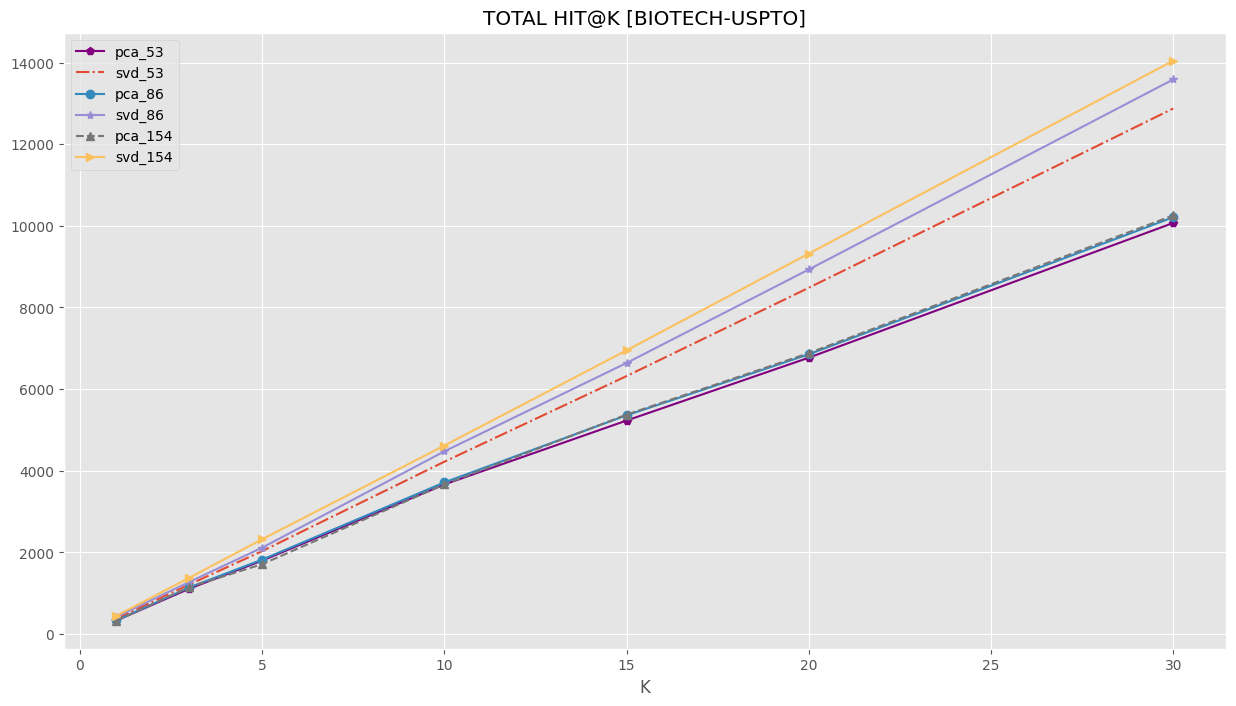

In [18]:


# plt.subplot(1,4,2)
plt.figure(figsize =(15,8))
plt.plot(k,hit_pca_53, '-p', color = 'purple')
plt.plot(k,hit_svd_53, '-.')
plt.plot(k,hit_pca_86, '-o')
plt.plot(k,hit_svd_86, '-*')
plt.plot(k,hit_pca_154, '--^')
plt.plot(k,hit_svd_154, '>-')
# plt.scatter(k,hit_pca_107, marker ='s',color= 'green')
# plt.plot(k,hit_svd_107, '--')
# plt.scatter(k,hit_svd_90, marker = 's', color= 'green')

plt.title('TOTAL HIT@K [BIOTECH-USPTO]')
plt.legend(['pca_53','svd_53','pca_86','svd_86','pca_154','svd_154'])
plt.xlabel('K');
     


In [19]:
print(hit_svd_53)
print(hit_svd_86)
print(hit_svd_154)
print(hit_svd_107)

[377, 1215, 2033, 4223, 6321, 8484, 12875]
[422, 1278, 2117, 4477, 6642, 8932, 13587]
[448, 1380, 2324, 4618, 6951, 9321, 14045]
[431, 1336, 2177, 4566, 6786, 9142, 13883]
